In [1]:
import gymnasium

from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login 

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [2]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

import pickle 
from tqdm.notebook import tqdm

In [3]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")

In [4]:
print(env.observation_space.sample())
print(env.observation_space.n)

4
16


In [5]:
print(env.action_space.sample())

0


In [6]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros. np.zeros needs a tuple (a,b)
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [7]:
state_space = env.observation_space.n 
action_space = env.action_space.n 

q_table = initialize_q_table(state_space, action_space)

In [8]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state, :])

  return action

In [9]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = np.random.uniform(0, 1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    action = np.random.choice(range(Qtable.shape[1]))

  return action

In [10]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7  # Learning rate

# Evaluation parameters
n_eval_episodes = 100  # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"  # Name of the environment
max_steps = 99  # Max steps per episode
gamma = 0.95  # Discounting rate
eval_seed = []  # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0  # Exploration probability at start
min_epsilon = 0.05  # Minimum exploration probability
decay_rate = 0.0005  # Exponential decay rate for exploration prob

In [11]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, _ = env.reset()
    terminated = False
    truncated = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, terminated, truncated, _ = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If terminated or truncated finish the episode
      if terminated or truncated:
        break

      # Our next state is the new state
      state = new_state
  return Qtable

In [12]:
q_table = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
np.round(q_table, 3)

array([[0.735, 0.774, 0.774, 0.735],
       [0.735, 0.   , 0.815, 0.774],
       [0.774, 0.857, 0.774, 0.815],
       [0.815, 0.   , 0.774, 0.774],
       [0.774, 0.815, 0.   , 0.735],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.902, 0.   , 0.815],
       [0.   , 0.   , 0.   , 0.   ],
       [0.815, 0.   , 0.857, 0.774],
       [0.815, 0.902, 0.902, 0.   ],
       [0.857, 0.95 , 0.   , 0.857],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.902, 0.95 , 0.857],
       [0.902, 0.95 , 1.   , 0.902],
       [0.   , 0.   , 0.   , 0.   ]])

In [14]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed=0):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for taxi-v3)
    """
    episode_rewards = []

    # Reset the environment
    for _ in range(n_eval_episodes):
        total_rewards = 0
        state, _ = env.reset()
        terminated = False
        truncated = False

        for _ in range(max_steps):
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, _  = env.step(action)
            
            state = new_state

            total_rewards += reward

            if terminated or truncated:
                break

        episode_rewards.append(total_rewards)


    return np.mean(episode_rewards), np.std(episode_rewards)
    

In [15]:
evaluate_agent(env, max_steps, n_eval_episodes, q_table, 0)

(1.0, 0.0)

In [16]:
from functions.huggingface_course import record_video, push_to_hub

In [17]:
record_video(env, q_table, "./data/frozen_lake.mp4")

In [18]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,
    "qtable": q_table,
}

In [19]:
# Doesn't seem to connect for now..

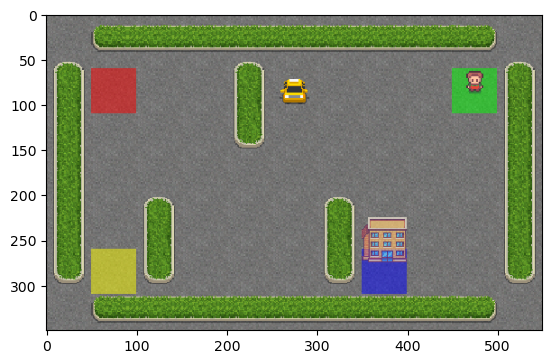

In [35]:
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [36]:
q_table = initialize_q_table(env.observation_space.n, env.action_space.n)

In [37]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7  # Learning rate

# Evaluation parameters
n_eval_episodes = 100  # Total number of test episodes

# Environment parameters
env_id = "Taxi-v3"  # Name of the environment
max_steps = 99  # Max steps per episode
gamma = 0.95  # Discounting rate
eval_seed = []  # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0  # Exploration probability at start
min_epsilon = 0.05  # Minimum exploration probability
decay_rate = 0.0005  # Exponential decay rate for exploration prob

In [38]:
q_table = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [39]:
record_video(env, q_table, "./data/taxi_v0.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6632100] Warning: data is not aligned! This can lead to a speed loss


In [64]:
q_table = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [65]:
record_video(env, q_table, "./data/taxi_v1.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f4e100] Warning: data is not aligned! This can lead to a speed loss
